# Ocean macronutrients

In [1]:
import xarray as xr
import glob
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import pop_tools
from dask.distributed import LocalCluster

In [2]:
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import pop_tools

## General setup (see previous two notebooks for explanations)

### Connect to cluster

In [3]:
from dask.distributed import LocalCluster
cluster = LocalCluster()
client = cluster.get_client()

/glade/work/eromashkova/miniconda3/envs/ocean-bgc-cookbook-dev/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39293 instead
  warnings.warn(
Task exception was never retrieved
future: <Task finished name='Task-1174466' coro=<Client._gather.<locals>.wait() done, defined at /glade/work/eromashkova/miniconda3/envs/ocean-bgc-cookbook-dev/lib/python3.11/site-packages/distributed/client.py:2208> exception=AllExit()>
Traceback (most recent call last):
  File "/glade/work/eromashkova/miniconda3/envs/ocean-bgc-cookbook-dev/lib/python3.11/site-packages/distributed/client.py", line 2217, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-1174468' coro=<Client._gather.<locals>.wait() done, defined at /glade/work/eromashkova/miniconda3/envs/ocean-bgc-cookbook-dev/lib/python3.11/site-packages/distributed/

### Bring in POP grid utilities

In [4]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
lons = ds_grid.TLONG
lats = ds_grid.TLAT
depths = ds_grid.z_t * 0.01

In [5]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    # Trick cartopy into doing the right thing:
    # it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8
    
    # Periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

### Load the data

In [6]:
case = 'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch'
path = '/glade/campaign/cesm/development/bgcwg/projects/CESM2-OMIP2-like-4p2z-run/'+case+'/ocn/proc/tseries/month_1'
coords = {'x':'TLONG','y':'TLAT'}
path

'/glade/campaign/cesm/development/bgcwg/projects/CESM2-OMIP2-like-4p2z-run/g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch/ocn/proc/tseries/month_1'

In [7]:
files = glob.glob(f'{path}/{case}.pop.h.*.195801-202112.nc')
ds=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True,
                       drop_variables=["transport_components", "transport_regions", 'moc_components'], decode_times=True)
ds

<xarray.Dataset>
Dimensions:                           (time: 768, nlat: 384, nlon: 320,
                                       z_t: 60, z_w: 60, lat_aux_grid: 395,
                                       moc_z: 61, d2: 2, z_t_150m: 15,
                                       z_w_bot: 60, z_w_top: 60,
                                       transport_reg: 2, moc_comp: 3,
                                       transport_comp: 5)
Coordinates:
    TLAT                              (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                             (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT                              (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULONG                             (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * lat_aux_grid                      (lat_aux_grid) float32 -79.49 ... 90.0
  * moc_z                             (moc_z) float32 0.0 1e+03 ... 5.5e+05
  * time                              (time) object 1958-02-01 00:00:00 ... 2...
  * z_t                               (z_t) float32 500.0 1.5e+03 ... 5.375e+05
  * z_t_150m                          (z_t_150m) float32 500.0 ... 1.45e+04
  * z_w                               (z_w) float32 0.0 1e+03 ... 5e+05 5.25e+05
  * z_w_bot                           (z_w_bot) float32 1e+03 2e+03 ... 5.5e+05
  * z_w_top                           (z_w_top) float32 0.0 1e+03 ... 5.25e+05
Dimensions without coordinates: nlat, nlon, d2, transport_reg, moc_comp,
                                transport_comp
Data variables: (12/544)
    ADVS                              (time, nlat, nlon) float32 dask.array<chunksize=(81, 124, 104), meta=np.ndarray>
    ANGLE                             (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ANGLET                            (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    DXT                               (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    DXU                               (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    DYT                               (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ...                                ...
    x_graze_mesozoo_zint              (time, nlat, nlon) float32 dask.array<chunksize=(81, 124, 104), meta=np.ndarray>
    x_graze_mesozoo_zint_100m         (time, nlat, nlon) float32 dask.array<chunksize=(81, 124, 104), meta=np.ndarray>
    x_graze_microzoo_zint             (time, nlat, nlon) float32 dask.array<chunksize=(81, 124, 104), meta=np.ndarray>
    x_graze_microzoo_zint_100m        (time, nlat, nlon) float32 dask.array<chunksize=(81, 124, 104), meta=np.ndarray>
    zsatarag                          (time, nlat, nlon) float32 dask.array<chunksize=(81, 124, 104), meta=np.ndarray>
    zsatcalc                          (time, nlat, nlon) float32 dask.array<chunksize=(81, 124, 104), meta=np.ndarray>
Attributes:
    title:             g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch
    history:           Wed Jun 21 09:15:38 2023: ncks -O -4 -L 1 /glade/scrat...
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2023-06-13 at 16:35:05.0
    cell_methods:      cell_methods = time: mean ==> the variable values are ...
    NCO:               netCDF Operators version 5.1.4 (Homepage = http://nco....

## Subsetting
Make our dataset smaller so it has just a couple of macronutrient variables we're interested in

In [8]:
variables =['PO4','NO3','SiO3']

In [9]:
keep_vars=['z_t','z_t_150m','dz','time_bound','time','TAREA','TLAT','TLONG'] + variables
ds = ds.drop_vars([v for v in ds.variables if v not in keep_vars])

Let's take a quick look at nitrate to make sure that things look okay

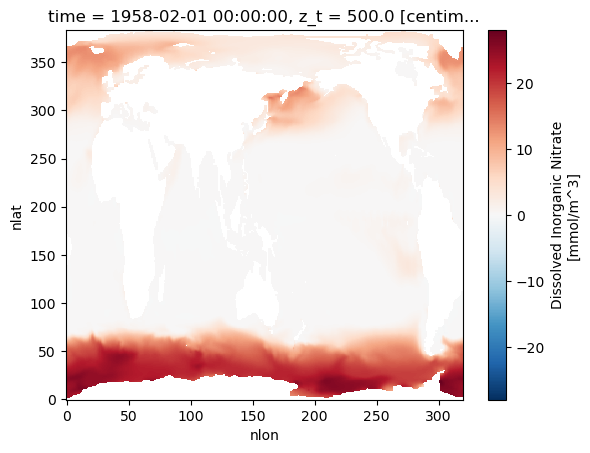

In [10]:
ds.NO3.isel(time=0,z_t=0).plot()

## Transforming from monthly to annual data
We can't just use xarray's regular `mean()` function because months have different numbers of days in them, so we have to weight by that to ensure the annual mean is accurate. See this [ESDS blog post](https://ncar.github.io/esds/posts/2021/yearly-averages-xarray/) for a more detailed explanation with examples!

In [11]:
def year_mean(ds):
    # Source: https://ncar.github.io/esds/posts/2021/yearly-averages-xarray/
    
    # Make a DataArray with the number of days in each month, size = len(time)
    month_length = ds.time.dt.days_in_month

    # Calculate the weights by grouping by 'time.season'
    weights = (
        month_length.groupby("time.year") / month_length.groupby("time.year").sum()
    )

    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weights.groupby("time.year").sum().values, np.ones((len(ds.groupby("time.year")), )))

    # Calculate the weighted average
    return (ds * weights).groupby("time.year").sum(dim="time")

In [20]:
ds_annual = year_mean(ds)
ds_annual

<xarray.Dataset>
Dimensions:   (nlat: 384, nlon: 320, z_t: 60, z_t_150m: 15, year: 65)
Coordinates:
    TLAT      (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * z_t       (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m  (z_t_150m) float32 500.0 1.5e+03 2.5e+03 ... 1.35e+04 1.45e+04
  * year      (year) int64 1958 1959 1960 1961 1962 ... 2018 2019 2020 2021 2022
Dimensions without coordinates: nlat, nlon
Data variables:
    TAREA     (year, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    dz        (year, z_t) float64 dask.array<chunksize=(1, 60), meta=np.ndarray>
    NO3       (year, z_t, nlat, nlon) float64 dask.array<chunksize=(1, 60, 384, 320), meta=np.ndarray>
    PO4       (year, z_t, nlat, nlon) float64 dask.array<chunksize=(1, 60, 384, 320), meta=np.ndarray>
    SiO3      (year, z_t, nlat, nlon) float64 dask.array<chunksize=(1, 60, 384, 320), meta=np.ndarray>

Note that our time coordinate is now called `year` instead, and has only years now. We can select specific years to plot:

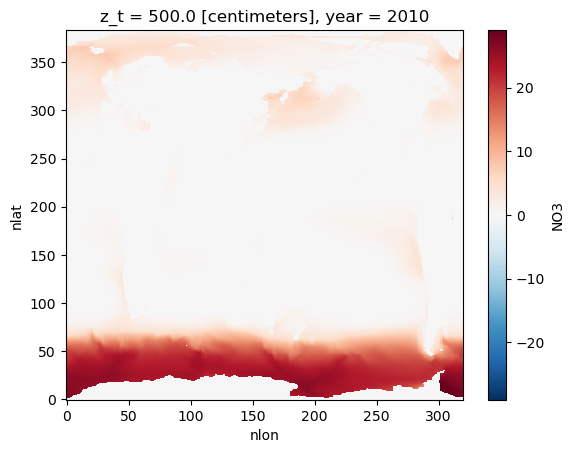

In [13]:
ds_annual['NO3'].sel(year=2010).isel(z_t=0).plot()

## Let's make a nicer-looking map

KeyboardInterrupt: 

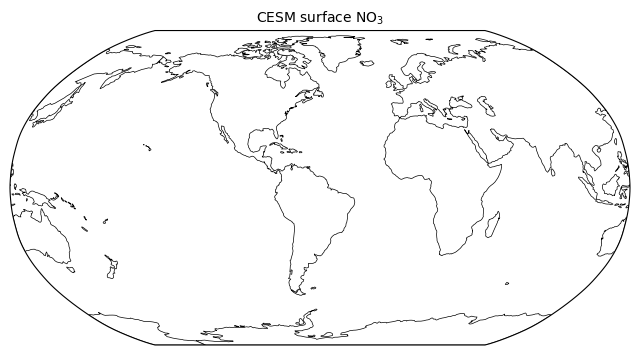

In [23]:
fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)

ax.set_title('CESM surface NO$_3$', fontsize=10)
lon, lat, field = adjust_pop_grid(lons, lats, ds_annual.NO3.sel(year=2010).isel(z_t=0))
pc1=ax.pcolormesh(lon, lat,field, vmin=0, vmax=20, cmap='Oranges',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

## Compare long-term mean to World Ocean Atlas 2018

- About the [World Ocean Atlas](https://www.ncei.noaa.gov/products/world-ocean-atlas)
- [Data access to WOA18](https://www.ncei.noaa.gov/access/world-ocean-atlas-2018/)

We've already regridded the WOA data to be on the same grid as the CESM POP data, so we don't need to worry about that step. However, if you wanted to compare to a dataset that's on a different grid, you'd need to go through the regridding process, which is beyond the scope of this cookbook.

This dataset has also already had a time mean taken, so there's no time coordinate.

**What do z_t, z_w, z_w_bot stand for?**

In [24]:
file = '/glade/work/kristenk/WOA_data/regrid_POP/WOA2018_POPgrid.nc' 
ds_woa = xr.load_dataset(file, decode_times=False, decode_coords=False)
ds_woa['z_t'] = ds.z_t
ds_woa

<xarray.Dataset>
Dimensions:      (z_t: 60, nlat: 384, nlon: 320, z_w: 60, z_w_bot: 60)
Coordinates:
  * z_t          (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_w          (z_w) float64 0.0 1e+03 2e+03 3e+03 ... 4.75e+05 5e+05 5.25e+05
  * z_w_bot      (z_w_bot) float64 1e+03 2e+03 3e+03 ... 5e+05 5.25e+05 5.5e+05
Dimensions without coordinates: nlat, nlon
Data variables: (12/17)
    TEMP         (z_t, nlat, nlon) float32 nan nan nan nan ... nan nan nan nan
    SALT         (z_t, nlat, nlon) float32 nan nan nan nan ... nan nan nan nan
    NO3          (z_t, nlat, nlon) float32 nan nan nan nan ... nan nan nan nan
    O2           (z_t, nlat, nlon) float32 nan nan nan nan ... nan nan nan nan
    SiO3         (z_t, nlat, nlon) float32 nan nan nan nan ... nan nan nan nan
    PO4          (z_t, nlat, nlon) float32 nan nan nan nan ... nan nan nan nan
    ...           ...
    DXT          (nlat, nlon) float64 2.339e+06 2.339e+06 ... 1.473e+06
    DYT          (nlat, nlon) float64 5.94e+06 5.94e+06 ... 5.046e+06 5.046e+06
    TAREA        (nlat, nlon) float64 1.39e+13 1.39e+13 ... 7.431e+12 7.432e+12
    KMT          (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    REGION_MASK  (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    dz           (z_t) float64 1e+03 1e+03 1e+03 ... 2.499e+04 2.5e+04 2.5e+04
Attributes:
    history:  created by kristen krumhardt on 2019-10-25

In [25]:
ds_mean = ds_annual.mean("year")

In [26]:
NO3_diff = ds_mean.NO3 - ds_woa.NO3
PO4_diff = ds_mean.PO4 - ds_woa.PO4
SiO3_diff = ds_mean.SiO3 - ds_woa.SiO3

### Surface comparison - REFORMAT AND FIX ALL DS -> DS_MEAN BELOW

KeyboardInterrupt: 

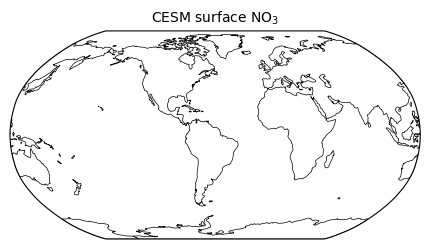

In [28]:
fig = plt.figure(figsize=(18,10))

####################NO3
#COLUMN 1  - NO3
#---- CESM panel
ax = fig.add_subplot(3,3,1, projection=ccrs.Robinson(central_longitude=305.0))
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)
ax.set_title('CESM surface NO$_3$', fontsize=10)
lon, lat, field = adjust_pop_grid(lons, lats, ds.NO3.isel(z_t=0))
pc1=ax.pcolormesh(lon, lat,field, vmin=0, vmax=20, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,4, projection=ccrs.Robinson(central_longitude=305.0))
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)
ax.set_title('WOA surface NO$_3$', fontsize=10)
lon, lat, field = adjust_pop_grid(lons, lats,  ds_woa.NO3.isel(z_t=0))
pc2=ax.pcolormesh(lon, lat, field, vmin=0, vmax=20, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,7, projection=ccrs.Robinson(central_longitude=305.0))
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)
ax.set_title('Surface NO$_3$ model bias', fontsize=10)
lon, lat, field = adjust_pop_grid(lons, lats,  NO3_diff.isel(z_t=0))
pc3=ax.pcolormesh(lon, lat, field, vmin=-10, vmax=10, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='NO$_3$ bias (mmol m$^{-3}$)')



####################PO4
#---- CESM panel
ax = fig.add_subplot(3,3,2, projection=ccrs.Robinson(central_longitude=305.0))
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)
ax.set_title('CESM surface PO$_4$', fontsize=10)
lon, lat, field = adjust_pop_grid(lons, lats, ds.PO4.isel(z_t=0))
pc1=ax.pcolormesh(lon, lat,field, vmin=0, vmax=2, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='PO$_4$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,5, projection=ccrs.Robinson(central_longitude=305.0))
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)
ax.set_title('WOA surface PO$_4$', fontsize=10)
lon, lat, field = adjust_pop_grid(lons, lats,  ds_woa.PO4.isel(z_t=0))
pc2=ax.pcolormesh(lon, lat,field, vmin=0, vmax=2, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='PO$_4$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,8, projection=ccrs.Robinson(central_longitude=305.0))
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)
ax.set_title('Surface PO$_4$ bias', fontsize=10)
lon, lat, field = adjust_pop_grid(lons, lats,  PO4_diff.isel(z_t=0))
pc3=ax.pcolormesh(lon, lat,field, vmin=-1, vmax=1, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='PO$_4$ bias (mmol m$^{-3}$)')



####################SiO3
#---- CESM panel
ax = fig.add_subplot(3,3,3, projection=ccrs.Robinson(central_longitude=305.0))
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)
ax.set_title('CESM surface SiO$_3$', fontsize=10)
lon, lat, field = adjust_pop_grid(lons, lats, ds.SiO3.isel(z_t=0))
pc1=ax.pcolormesh(lon, lat, field, 
                  vmin=0, vmax=30, 
                  cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='SiO$_3$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,6, projection=ccrs.Robinson(central_longitude=305.0))
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)
ax.set_title('WOA surface SiO$_3$', fontsize=10)
lon, lat, field = adjust_pop_grid(lons, lats,  ds_woa.SiO3.isel(z_t=0))
pc2=ax.pcolormesh(lon, lat,field, 
                  vmin=0, vmax=30, 
                  cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='SiO$_3$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,9, projection=ccrs.Robinson(central_longitude=305.0))
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)
ax.set_title('Surface SiO$_3$ bias', fontsize=10)
lon, lat, field = adjust_pop_grid(lons, lats,  SiO3_diff.isel(z_t=0))
pc3=ax.pcolormesh(lon, lat, field, 
                  vmin=-15, vmax=15, 
                  cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='SiO$_3$ bias (mmol m$^{-3}$)');

### Comparison at 100m

In [ ]:
fig = plt.figure(figsize=(18,10))

####################NO3
#COLUMN 1  - NO3
#---- CESM panel
ax = fig.add_subplot(3,3,1, projection=ccrs.Robinson(central_longitude=305.0))
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)
ax.set_title('CESM 100m NO$_3$', fontsize=10)
lon, lat, field = util.adjust_pop_grid(lons, lats, ds.NO3.isel(z_t=10))
pc1=ax.pcolormesh(lon, lat,field, vmin=0, vmax=20, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,4, projection=ccrs.Robinson(central_longitude=305.0))
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)
ax.set_title('WOA 100m NO$_3$', fontsize=10)
lon, lat, field = util.adjust_pop_grid(lons, lats,  ds_woa.NO3.isel(z_t=10))
pc2=ax.pcolormesh(lon, lat, field, vmin=0, vmax=20, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,7, projection=ccrs.Robinson(central_longitude=305.0))
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)
ax.set_title('100m NO$_3$ model bias', fontsize=10)
lon, lat, field = util.adjust_pop_grid(lons, lats,  NO3_diff.isel(z_t=10))
pc3=ax.pcolormesh(lon, lat, field, vmin=-10, vmax=10, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='NO$_3$ bias (mmol m$^{-3}$)')



####################PO4
#---- CESM panel
ax = fig.add_subplot(3,3,2, projection=ccrs.Robinson(central_longitude=305.0))
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)
ax.set_title('CESM 100m PO$_4$', fontsize=10)
lon, lat, field = util.adjust_pop_grid(lons, lats, ds.PO4.isel(z_t=10))
pc1=ax.pcolormesh(lon, lat,field, vmin=0, vmax=2, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='PO$_4$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,5, projection=ccrs.Robinson(central_longitude=305.0))
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)
ax.set_title('WOA 100m PO$_4$', fontsize=10)
lon, lat, field = util.adjust_pop_grid(lons, lats,  ds_woa.PO4.isel(z_t=10))
pc2=ax.pcolormesh(lon, lat,field, vmin=0, vmax=2, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='PO$_4$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,8, projection=ccrs.Robinson(central_longitude=305.0))
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)
ax.set_title('100m PO$_4$ bias', fontsize=10)
lon, lat, field = util.adjust_pop_grid(lons, lats,  PO4_diff.isel(z_t=10))
pc3=ax.pcolormesh(lon, lat,field, vmin=-1, vmax=1, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='PO$_4$ bias (mmol m$^{-3}$)')



####################SiO3
#---- CESM panel
ax = fig.add_subplot(3,3,3, projection=ccrs.Robinson(central_longitude=305.0))
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)
ax.set_title('CESM 100m SiO$_3$', fontsize=10)
lon, lat, field = util.adjust_pop_grid(lons, lats, ds.SiO3.isel(z_t=10))
pc1=ax.pcolormesh(lon, lat, field, 
                  vmin=0, vmax=30, 
                  cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='SiO$_3$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,6, projection=ccrs.Robinson(central_longitude=305.0))
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)
ax.set_title('WOA 100m SiO$_3$', fontsize=10)
lon, lat, field = util.adjust_pop_grid(lons, lats,  ds_woa.SiO3.isel(z_t=10))
pc2=ax.pcolormesh(lon, lat,field, 
                  vmin=0, vmax=30, 
                  cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='SiO$_3$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,9, projection=ccrs.Robinson(central_longitude=305.0))
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)
ax.set_title('100m SiO$_3$ bias', fontsize=10)
lon, lat, field = util.adjust_pop_grid(lons, lats,  SiO3_diff.isel(z_t=10))
pc3=ax.pcolormesh(lon, lat, field, 
                  vmin=-15, vmax=15, 
                  cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='SiO$_3$ bias (mmol m$^{-3}$)');

## Global mean macronutrient profiles

In [ ]:
ds_glb = util.global_mean(ds, ds_grid, ['NO3','PO4','SiO3']).compute()

In [ ]:
ds_glb_woa = util.global_mean(ds_woa, ds_grid, ['NO3','PO4','SiO3']).compute()

In [ ]:
fig = plt.figure(figsize=(15,10))

plt.suptitle('Global mean macronutrient profiles', fontsize=14)


#COLUMN 1  - NO3

ax = fig.add_subplot(2,3,1)
ax.set_title('Global mean NO$_3$')
ax.plot(ds_glb['NO3'].values, depths, label='CESM', linewidth=3)
ax.plot(ds_glb_woa['NO3'].values, depths, label='WOA', linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='NO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 2  - PO4

ax = fig.add_subplot(2,3,2)
ax.set_title('Global mean PO$_4$')
ax.plot(ds_glb['PO4'].values, depths, label='CESM', linewidth=3)
ax.plot(ds_glb_woa['PO4'].values, depths, label='WOA', linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='PO$_4$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 3  - SiO3

ax = fig.add_subplot(2,3,3)
ax.set_title('Global mean SiO$_3$')
ax.plot(ds_glb['SiO3'].values, depths, label='CESM', linewidth=3)
ax.plot(ds_glb_woa['SiO3'].values, depths, label='WOA', linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='SiO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()


#COLUMN 1  - NO3 diff

ax = fig.add_subplot(2,3,4)
ax.plot(ds_glb['NO3'].values - ds_glb_woa['NO3'].values, depths, label='bias', linewidth=3, color='green')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='NO$_3$ bias (mmol m$^{-3}$)')
ax.axvline(x=0,color='black',linestyle='--',linewidth=0.5)
plt.gca().invert_yaxis()

#COLUMN 2  - PO4 diff

ax = fig.add_subplot(2,3,5)
ax.plot(ds_glb['PO4'].values - ds_glb_woa['PO4'].values, depths, label='bias', linewidth=3, color='green')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='PO$_4$ bias (mmol m$^{-3}$)')
ax.axvline(x=0,color='black',linestyle='--',linewidth=0.5)
plt.gca().invert_yaxis()

#COLUMN 3  - SiO3 diff

ax = fig.add_subplot(2,3,6)
ax.plot(ds_glb['SiO3'].values - ds_glb_woa['SiO3'].values, depths, label='bias', linewidth=3, color='green')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='SiO$_3$ bias (mmol m$^{-3}$)')
ax.axvline(x=0,color='black',linestyle='--',linewidth=0.5)
plt.gca().invert_yaxis()

